In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


x_npy_path = "super/X_scaled.npy"
y_npy_path = "super/y.npy"
X_full = np.load(x_npy_path)
y = np.load(y_npy_path)

print("X shape:", X_full.shape)
print("y shape:", y.shape)
seed = np.random.randint(0, 2**32 - 1)
n_jobs = -1
kf = KFold(n_splits=2, shuffle=True, random_state=seed)
D = X_full.shape[1]
fold_metrics = []

for k, (tr_idx, te_idx) in enumerate(kf.split(X_full), start=1):
    X_tr, X_te = X_full[tr_idx], X_full[te_idx]
    y_tr, y_te = y[tr_idx], y[te_idx]

    reg = RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=3,
        random_state=seed,
        n_jobs=n_jobs
    )
    reg.fit(X_tr, y_tr)
    y_pred = reg.predict(X_te)

    r2 = r2_score(y_te, y_pred)

    try:
        from sklearn.metrics import root_mean_squared_error
        rmse = root_mean_squared_error(y_te, y_pred)
    except Exception:
        rmse = np.sqrt(mean_squared_error(y_te, y_pred))
    mae = mean_absolute_error(y_te, y_pred)

    fold_metrics.append((r2, rmse, mae))
    print(f"Fold {k}: R2={r2:.4f} | RMSE={rmse:.4f} | MAE={mae:.4f}")

r2s, rmses, maes = map(np.array, zip(*fold_metrics))
print(f"Mean (2-fold): R2={r2s.mean():.4f} ± {r2s.std(ddof=1):.4f} | "
      f"RMSE={rmses.mean():.4f} ± {rmses.std(ddof=1):.4f} | "
      f"MAE={maes.mean():.4f} ± {maes.std(ddof=1):.4f}")


X shape: (21263, 81)
y shape: (21263,)
Fold 1: R2=0.9145 | RMSE=10.0268 | MAE=5.8514
Fold 2: R2=0.9087 | RMSE=10.3434 | MAE=5.8860
Mean (2-fold): R2=0.9116 ± 0.0041 | RMSE=10.1851 ± 0.2238 | MAE=5.8687 ± 0.0245


# FDFI

/root/miniconda3/lib/python3.12/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
Training: 100%|█████████████████████████████████| 50000/50000 [03:12<00:00, 259.56it/s, loss=0.5974]


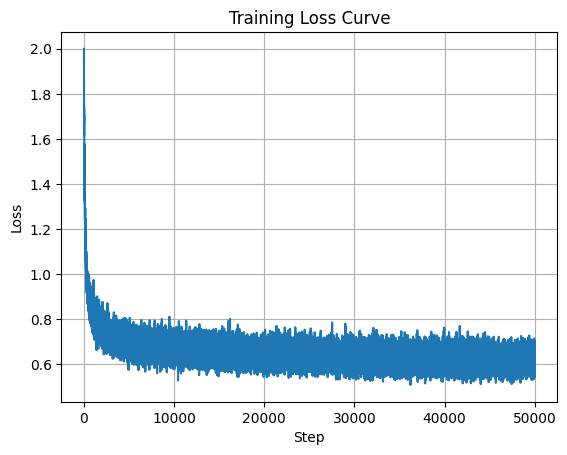

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from Flow_Disentangle_Feature_Importance import FlowMatchingModel

model = FlowMatchingModel(
    X=X_full,
    dim=D,
    device=device,
    hidden_dim=128,        
    time_embed_dim=64,     
    num_blocks=1,
    use_bn=False,
    seed=seed
)
model.fit(num_steps=50000, batch_size=256, lr=1e-3, show_plot=True)

In [ ]:

from Flow_Disentangle_Feature_Importance import CPI_Flow_Model_Estimator
from scipy.stats import norm
from sklearn.ensemble import RandomForestRegressor
import numpy as np
estimator3 = CPI_Flow_Model_Estimator(
    random_state=seed,
    regressor =  RandomForestRegressor(
                n_estimators=400,
                max_depth=None,
                min_samples_leaf=4,
                random_state=seed,
                n_jobs=n_jobs
                ),
    flow_model=model
)

phi_x_cpi, se_x_cpi = estimator3.importance(X_full, y)

print("Feature\tFDFI φ\tStdError")
for j, (phi_j, se_j) in enumerate(zip(phi_x_cpi, se_x_cpi)):
    print(f"{j:>3d}\t{phi_j: .4f}\t{se_j: .4f}")
print(f"Sum of FDFI: {D* np.mean(phi_x_cpi)}")

phi_x_cpi_test = phi_x_cpi 

se_x_cpi_test = se_x_cpi 

z_score_x_cpi = phi_x_cpi_test / se_x_cpi_test

p_value_x_cpi = 1 - norm.cdf(z_score_x_cpi)
rounded_p_value_x_cpi = np.round(p_value_x_cpi, 3)

print(rounded_p_value_x_cpi)

alpha = 0.05 / 81  

mask = (p_value_x_cpi <= alpha).astype(int)

print(mask)

CPI@Z (resample) → decode → X: 100%|██████████| 81/81 [01:51<00:00,  1.37s/it]
/root/autodl-tmp/Module_Flow_Disentangle_Feature_Importance/Flow_Disentangle_Feature_Importance/Flow_Matching/flow_matching.py:213: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  t_tensor = torch.tensor([[float(t_scalar)]], dtype=torch.float32, device=self.device)


H: 805.837s


CPI@Z (resample) → decode → X: 100%|██████████| 81/81 [01:54<00:00,  1.41s/it]


H: 803.646s
Feature	FDFI φ	StdError
  0	 469.5860	 10.4290
  1	 337.1040	 6.9356
  2	 348.8266	 7.1148
  3	 386.3120	 7.8980
  4	 334.7976	 6.8450
  5	 268.1137	 5.2194
  6	 241.2008	 4.7427
  7	 991.2727	 24.4341
  8	 385.7003	 7.9479
  9	 728.9471	 16.7653
 10	 1169.4123	 29.3731
 11	 821.1439	 18.8012
 12	 450.4969	 9.7986
 13	 598.6708	 13.0559
 14	 360.1100	 7.3651
 15	 352.7876	 7.1161
 16	 620.6892	 13.3452
 17	 1115.0638	 28.5830
 18	 256.4418	 5.2241
 19	 1025.9165	 25.7672
 20	 1110.2879	 28.7019
 21	 682.2474	 15.3806
 22	 395.4000	 8.2426
 23	 1112.2802	 26.9256
 24	 568.3588	 12.9301
 25	 338.9280	 6.7501
 26	 330.3912	 6.7687
 27	 629.4126	 14.8907
 28	 298.6586	 6.0897
 29	 524.7667	 11.4946
 30	 581.4605	 13.3594
 31	 544.8940	 11.9966
 32	 524.6624	 11.5106
 33	 1328.1927	 33.8342
 34	 1192.5721	 29.6988
 35	 315.5957	 6.1588
 36	 316.0363	 6.2069
 37	 412.7433	 8.4493
 38	 417.9257	 8.5350
 39	 428.0697	 8.8270
 40	 596.5500	 12.9690
 41	 596.9749	 12.8595
 42	 841.03

# DFI

In [ ]:
from Flow_Disentangle_Feature_Importance import  DFIEstimator
from scipy.stats import norm
from sklearn.ensemble import RandomForestRegressor
import numpy as np

estimator4 = DFIEstimator(
    random_state=seed,
    regressor =  RandomForestRegressor(
                n_estimators=400,
                max_depth=None,
                min_samples_leaf=4,
                random_state=seed,
                n_jobs=n_jobs
                )
)

phi_x_dfi, se_x_dfi = estimator4.importance(X_full, y)


print("Feature\tDFI φ\tStdError")
for j, (phi_j, se_j) in enumerate(zip(phi_x_dfi, se_x_dfi)):
    print(f"{j:>3d}\t{phi_j: .4f}\t{se_j: .4f}")
print(f"Sum of DFI: {D* np.mean(phi_x_dfi)}")

phi_x_dfi_test = phi_x_dfi 

se_x_dfi_test = se_x_dfi 

z_score_x_dfi = phi_x_dfi_test / se_x_dfi_test

p_value_x_dfi = 1 - norm.cdf(z_score_x_dfi)
rounded_p_value_x_dfi = np.round(p_value_x_dfi, 3)

print(rounded_p_value_x_dfi)

alpha = 0.05 / 81 

mask = (p_value_x_dfi <= alpha).astype(int)

print(mask)



/root/miniconda3/lib/python3.12/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Feature	DFI φ	StdError
  0	 665.7696	 12.8513
  1	 490.0511	 9.2354
  2	 560.1455	 10.9679
  3	 508.5160	 9.6036
  4	 573.5714	 11.1671
  5	 656.8141	 12.6535
  6	 666.6009	 12.7893
  7	 645.6807	 12.5412
  8	 597.4675	 11.8275
  9	 621.8626	 12.3480
 10	 617.1628	 12.0839
 11	 478.9034	 9.3233
 12	 608.7470	 11.8694
 13	 459.2295	 9.0808
 14	 597.8762	 11.7173
 15	 661.6589	 12.7337
 16	 643.3428	 12.2808
 17	 664.6034	 12.5932
 18	 602.7779	 11.7257
 19	 655.9477	 12.4520
 20	 655.6657	 12.5927
 21	 537.6336	 10.3099
 22	 601.8826	 11.7707
 23	 551.1928	 10.5186
 24	 618.3956	 12.0377
 25	 660.7345	 12.7303
 26	 666.4839	 12.8057
 27	 685.7273	 13.0177
 28	 629.1320	 12.5430
 29	 673.9852	 12.7475
 30	 672.1887	 12.8346
 31	 620.7627	 11.7510
 32	 634.6083	 12.2194
 33	 650.5288	 12.3101
 34	 647.2007	 12.3430
 35	 646.7752	 12.5054
 36	 647.0690	 12.6170
 37	 538.4886	 11.0191
 38	 597.9059	 11.7605
 39	 521.3331	 10.6891
 40	 544.0812	 10.8161
 41	 510.3526	 10.2198
 42	 520.0792	 

# ad hoc method

## CPI

In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

n, D = X_full.shape

ctg_names = [
    "LB","AC","FM","UC","DL","DS","DP",
    "ASTV","MSTV","ALTV","MLTV",
    "Width","Min","Max","Nmax","Nzeros","Mode","Mean","Median","Variance","Tendency"
]
feature_names = ctg_names if D == 21 else [f"f{i}" for i in range(D)]
X_df = pd.DataFrame(X_full, columns=feature_names)

corr = spearmanr(X_df).correlation
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1.0)
corr = np.nan_to_num(corr, nan=0.0, posinf=0.0, neginf=0.0)

distance_matrix = 1.0 - np.abs(corr)
linkage = hierarchy.ward(squareform(distance_matrix))


t = 0.515
cluster_ids = hierarchy.fcluster(linkage, t, criterion="distance")
cluster_to_ids = defaultdict(list)
for idx, cid in enumerate(cluster_ids):
    cluster_to_ids[cid].append(idx)


def select_representatives(
    X: np.ndarray,
    y: np.ndarray,
    cluster_to_ids: dict,
    corr_abs: np.ndarray,           # |spearman|
    dist: np.ndarray,               # 1 - |spearman|
    strategy: str = "medoid",
    random_state: int = 0
):
    rng = np.random.RandomState(random_state)
    selected = []

    for cid, ids in cluster_to_ids.items():
        ids = list(ids)
        if len(ids) == 1:
            selected.append(ids[0])
            continue

        if strategy == "first":
            chosen = ids[0]

        elif strategy == "medoid":

            subD = dist[np.ix_(ids, ids)]
            sums = np.sum(subD, axis=1)
            chosen = ids[int(np.argmin(sums))]
        selected.append(chosen)

    return selected

strategy = "medoid"   
selected_feature_idx = select_representatives(
    X_full, y, cluster_to_ids,
    corr_abs=np.abs(corr),
    dist=distance_matrix,
    strategy=strategy,
    random_state=0
)
selected_feature_names = [feature_names[i] for i in selected_feature_idx]
print(f"[{strategy}] selected numbers: {len(selected_feature_idx)}")
print(" selected names:", selected_feature_names)


X_subset = X_full[:, selected_feature_idx]


seed = seed
n_jobs = -1  
kf = KFold(n_splits=2, shuffle=True, random_state=seed)

fold_metrics = []
for k, (tr_idx, te_idx) in enumerate(kf.split(X_subset), start=1):
    X_tr, X_te = X_subset[tr_idx], X_subset[te_idx]
    y_tr, y_te = y[tr_idx], y[te_idx]

    reg = RandomForestRegressor(
        n_estimators=400,
        max_depth=None,
        min_samples_leaf=4,
        random_state=seed,
        n_jobs=n_jobs
    )
    reg.fit(X_tr, y_tr)
    y_pred = reg.predict(X_te)


    r2 = r2_score(y_te, y_pred)
    rmse = np.sqrt(mean_squared_error(y_te, y_pred))  
    mae = mean_absolute_error(y_te, y_pred)  

    fold_metrics.append((r2, rmse, mae))
    print(f"Fold {k} (selected features): R2={r2:.4f} | RMSE={rmse:.4f} | MAE={mae:.4f}")


r2s, rmses, maes = map(np.array, zip(*fold_metrics))
print(f"Mean (2-fold, selected features): "
      f"R2={r2s.mean():.4f} ± {r2s.std(ddof=1):.4f} | "
      f"RMSE={rmses.mean():.4f} ± {rmses.std(ddof=1):.4f} | "
      f"MAE={maes.mean():.4f} ± {maes.std(ddof=1):.4f}")


print("Selected indices:", selected_feature_idx)


[medoid] selected numbers: 20
 selected names: ['f0', 'f3', 'f4', 'f9', 'f8', 'f23', 'f24', 'f16', 'f29', 'f54', 'f41', 'f42', 'f49', 'f57', 'f62', 'f65', 'f67', 'f71', 'f79', 'f78']
Fold 1 (selected features): R2=0.9070 | RMSE=10.4546 | MAE=6.0827
Fold 2 (selected features): R2=0.9008 | RMSE=10.7792 | MAE=6.2048
Mean (2-fold, selected features): R2=0.9039 ± 0.0044 | RMSE=10.6169 ± 0.2295 | MAE=6.1437 ± 0.0863
Selected indices: [0, 3, 4, 9, 8, 23, 24, 16, 29, 54, 41, 42, 49, 57, 62, 65, 67, 71, 79, 78]


In [ ]:
from Flow_Disentangle_Feature_Importance import CPIEstimator
from scipy.stats import norm
import numpy as np

estimator5 = CPIEstimator(
        random_state=seed,
        regressor =  RandomForestRegressor(
                n_estimators=400,
                max_depth=None,
                min_samples_leaf=4,
                random_state=seed,
                n_jobs=n_jobs
                )

)

phi_0_cpi_ad_hoc, se_0_cpi_ad_hoc = estimator5.importance(X_subset, y)


print("Feature\tCPI__ad_hoc φ\tStdError")
for j, (phi_j, se_j) in enumerate(zip(phi_0_cpi_ad_hoc, se_0_cpi_ad_hoc)):
    print(f"{j:>3d}\t{phi_j: .4f}\t{se_j: .4f}")
print(f"Sum of CPI__ad_hoc: {D* np.mean(phi_0_cpi_ad_hoc)}")


phi_0_cpi_test_ad_hoc = phi_0_cpi_ad_hoc 

se_0_cpi_test_ad_hoc = se_0_cpi_ad_hoc 

z_score_0_cpi_ad_hoc = phi_0_cpi_test_ad_hoc / se_0_cpi_ad_hoc

p_value_0_cpi_ad_hoc = 1 - norm.cdf(z_score_0_cpi_ad_hoc)
rounded_p_value_0_cpi_ad_hoc = np.round(p_value_0_cpi_ad_hoc, 3)

print(rounded_p_value_0_cpi_ad_hoc)

alpha = 0.05 / 20  

mask = (p_value_0_cpi_ad_hoc <= alpha).astype(int)

print(mask)




CPI conditional permutation: 100%|██████████| 20/20 [00:14<00:00,  1.38it/s]

Feature	CPI__ad_hoc φ	StdError
  0	 0.1662	 0.0284
  1	 3.4207	 0.2389
  2	 5.6924	 0.3216
  3	 55.6952	 1.8338
  4	 10.4578	 0.4648
  5	 2.7695	 0.1843
  6	 6.1767	 0.2959
  7	 13.3656	 0.6056
  8	 23.1484	 0.7184
  9	 10.6704	 0.4061
 10	 1.5814	 0.1411
 11	 23.4416	 0.7872
 12	 19.7597	 0.8111
 13	 1.2459	 0.1165
 14	 72.6935	 1.6580
 15	 11.2070	 0.6809
 16	 425.7816	 8.0737
 17	 9.5555	 0.4660
 18	 4.7670	 0.2931
 19	 29.8114	 1.0273
Sum of CPI__ad_hoc: 2962.1991254109216
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


top_k = 2
D = X_full.shape[1]


phi_safe = np.nan_to_num(phi_0_cpi_ad_hoc, nan=-np.inf, posinf=-np.inf, neginf=-np.inf)


top_k = min(top_k, D)
order = np.argsort(phi_safe)[::-1]  
selected_feature_idx = order[:top_k].tolist()

print(f"Top-{top_k} feature indices by CPI_ad_hoc:")
for rank, j in enumerate(selected_feature_idx, start=1):
    print(f"  #{rank}: idx={j:4d}, CPI_ad_hoc={phi_0_cpi_ad_hoc[j]:.6f}, SE={se_0_cpi_ad_hoc[j]:.6f}")


X_subset = X_full[:, selected_feature_idx]
print("X_subset shape:", X_subset.shape)


seed = seed
n_jobs = n_jobs  

kf = KFold(n_splits=2, shuffle=True, random_state=seed)
fold_metrics = []

for k, (tr_idx, te_idx) in enumerate(kf.split(X_subset), start=1):
    X_tr, X_te = X_subset[tr_idx], X_subset[te_idx]
    y_tr, y_te = y[tr_idx], y[te_idx]

    reg = RandomForestRegressor(
        n_estimators=400,
        max_depth=None,
        min_samples_leaf=4,
        random_state=seed,
        n_jobs=n_jobs
    )
    reg.fit(X_tr, y_tr)
    y_pred = reg.predict(X_te)


    r2 = r2_score(y_te, y_pred)
    try:
        from sklearn.metrics import root_mean_squared_error
        rmse = root_mean_squared_error(y_te, y_pred)
    except Exception:
        rmse = np.sqrt(mean_squared_error(y_te, y_pred))
    mae = mean_absolute_error(y_te, y_pred)

    fold_metrics.append((r2, rmse, mae))
    print(f"Fold {k} (selected features): R2={r2:.4f} | RMSE={rmse:.4f} | MAE={mae:.4f}")

# 汇总两折的结果
r2s, rmses, maes = map(np.array, zip(*fold_metrics))
print(f"Mean (2-fold, selected features): "
      f"R2={r2s.mean():.4f} ± {r2s.std(ddof=1):.4f} | "
      f"RMSE={rmses.mean():.4f} ± {rmses.std(ddof=1):.4f} | "
      f"MAE={maes.mean():.4f} ± {maes.std(ddof=1):.4f}")

print("Selected indices:", selected_feature_idx)


Top-2 feature indices by CPI_ad_hoc:
  #1: idx=  16, CPI_ad_hoc=425.781601, SE=8.073728
  #2: idx=  14, CPI_ad_hoc=72.693452, SE=1.658014
X_subset shape: (21263, 2)
Fold 1 (selected features): R2=0.7347 | RMSE=17.6559 | MAE=10.8580
Fold 2 (selected features): R2=0.7230 | RMSE=18.0133 | MAE=10.9470
Mean (2-fold, selected features): R2=0.7289 ± 0.0083 | RMSE=17.8346 ± 0.2527 | MAE=10.9025 ± 0.0630
Selected indices: [16, 14]


| Top-k | R^2 | RMSE     | MAE |
|:------|:--------:|:--------:|:-------:|
| Top-10 | 0.8822 ± 0.0060  | 11.7546 ± 0.2869  | 6.8453 ± 0.0454   |
| Top-8  | 0.8771 ± 0.0038  | 12.0083 ± 0.1705 | 7.0183 ± 0.0031       |
| Top-6  | 0.8701 ± 0.0054  | 12.3431 ± 0.2400  | 7.2359 ± 0.0141     |
| Top-4  | 0.8532 ± 0.0041 | 13.1241 ± 0.1662  |  7.7349 ± 0.0449    |
| Top-2  | 0.7289 ± 0.0083  | 17.8346 ± 0.2527 |  10.9025 ± 0.0630     |

## FDFI

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


D = X_full.shape[1]
top_k = 2  


phi_safe = np.nan_to_num(phi_x_cpi, nan=-np.inf, posinf=-np.inf, neginf=-np.inf)


top_k = min(top_k, D)
order = np.argsort(phi_safe)[::-1] 
selected_feature_idx = order[:top_k].tolist()

print(f"Top-{top_k} feature indices by CPI:")
for rank, j in enumerate(selected_feature_idx, start=1):
    print(f"  #{rank}: idx={j:4d}, CPI={phi_x_cpi[j]:.6f}, SE={se_x_cpi[j]:.6f}")

X_subset = X_full[:, selected_feature_idx]
print("X_subset shape:", X_subset.shape)


seed = seed
n_jobs = -1
kf = KFold(n_splits=2, shuffle=True, random_state=seed)
fold_metrics = []

for k, (tr_idx, te_idx) in enumerate(kf.split(X_subset), start=1):
    X_tr, X_te = X_subset[tr_idx], X_subset[te_idx]
    y_tr, y_te = y[tr_idx], y[te_idx]

    reg = RandomForestRegressor(
        n_estimators=400,
        max_depth=None,
        min_samples_leaf=4,
        random_state=seed,
        n_jobs=n_jobs
    )
    reg.fit(X_tr, y_tr)
    y_pred = reg.predict(X_te)

    r2 = r2_score(y_te, y_pred)

    try:
        from sklearn.metrics import root_mean_squared_error
        rmse = root_mean_squared_error(y_te, y_pred)
    except Exception:
        rmse = np.sqrt(mean_squared_error(y_te, y_pred))
    mae = mean_absolute_error(y_te, y_pred)

    fold_metrics.append((r2, rmse, mae))
    print(f"Fold {k} (selected features): R2={r2:.4f} | RMSE={rmse:.4f} | MAE={mae:.4f}")

r2s, rmses, maes = map(np.array, zip(*fold_metrics))
print(f"Mean (2-fold, selected features): "
      f"R2={r2s.mean():.4f} ± {r2s.std(ddof=1):.4f} | "
      f"RMSE={rmses.mean():.4f} ± {rmses.std(ddof=1):.4f} | "
      f"MAE={maes.mean():.4f} ± {maes.std(ddof=1):.4f}")

print("Selected indices:", selected_feature_idx)


Top-2 feature indices by CPI:
  #1: idx=  63, CPI=1704.612005, SE=43.341321
  #2: idx=  33, CPI=1328.192744, SE=33.834161
X_subset shape: (21263, 2)
Fold 1 (selected features): R2=0.8120 | RMSE=14.8647 | MAE=9.3664
Fold 2 (selected features): R2=0.8014 | RMSE=15.2507 | MAE=9.4723
Mean (2-fold, selected features): R2=0.8067 ± 0.0075 | RMSE=15.0577 ± 0.2730 | MAE=9.4193 ± 0.0749
Selected indices: [63, 33]


| Top-k | R^2 | RMSE     | MAE |
|:------|:--------:|:--------:|:-------:|
| Top-10 | 0.8960 ± 0.0041  | 11.0460 ± 0.2040  | 6.4584 ± 0.0180   |
| Top-8  | 0.8962 ± 0.0067   | 11.0347 ± 0.3426  | 6.4984 ± 0.0398       |
| Top-6  | 0.8909 ± 0.0048  | 11.3138 ± 0.2369  | 6.6486 ± 0.0080      |
| Top-4  | 0.8603 ± 0.0081  | 12.7988 ± 0.3559  |  7.5222 ± 0.0582    |
| Top-2  | 0.8067 ± 0.0075  | 15.0577 ± 0.2730 |  9.4193 ± 0.0749     |

## DFI

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


top_k = 2
D = X_full.shape[1]


phi_safe = np.nan_to_num(phi_x_dfi, nan=-np.inf, posinf=-np.inf, neginf=-np.inf)


top_k = min(top_k, D)
order = np.argsort(phi_safe)[::-1]  
selected_feature_idx = order[:top_k].tolist()

print(f"Top-{top_k} feature indices by DFI:")
for rank, j in enumerate(selected_feature_idx, start=1):
    print(f"  #{rank}: idx={j:4d}, DFI={phi_x_dfi[j]:.6f}, SE={se_x_dfi[j]:.6f}")


X_subset = X_full[:, selected_feature_idx]
print("X_subset shape:", X_subset.shape)


seed = seed
n_jobs = n_jobs  

kf = KFold(n_splits=2, shuffle=True, random_state=seed)
fold_metrics = []

for k, (tr_idx, te_idx) in enumerate(kf.split(X_subset), start=1):
    X_tr, X_te = X_subset[tr_idx], X_subset[te_idx]
    y_tr, y_te = y[tr_idx], y[te_idx]

    reg = RandomForestRegressor(
        n_estimators=400,
        max_depth=None,
        min_samples_leaf=4,
        random_state=seed,
        n_jobs=n_jobs
    )
    reg.fit(X_tr, y_tr)
    y_pred = reg.predict(X_te)


    r2 = r2_score(y_te, y_pred)
    try:

        from sklearn.metrics import root_mean_squared_error
        rmse = root_mean_squared_error(y_te, y_pred)
    except Exception:
        rmse = np.sqrt(mean_squared_error(y_te, y_pred))
    mae = mean_absolute_error(y_te, y_pred)

    fold_metrics.append((r2, rmse, mae))
    print(f"Fold {k} (selected features): R2={r2:.4f} | RMSE={rmse:.4f} | MAE={mae:.4f}")


r2s, rmses, maes = map(np.array, zip(*fold_metrics))
print(f"Mean (2-fold, selected features): "
      f"R2={r2s.mean():.4f} ± {r2s.std(ddof=1):.4f} | "
      f"RMSE={rmses.mean():.4f} ± {rmses.std(ddof=1):.4f} | "
      f"MAE={maes.mean():.4f} ± {maes.std(ddof=1):.4f}")


print("Selected indices:", selected_feature_idx)


Top-2 feature indices by DFI:
  #1: idx=  27, DFI=685.727287, SE=13.017670
  #2: idx=  64, DFI=685.495200, SE=13.564653
X_subset shape: (21263, 2)
Fold 1 (selected features): R2=0.7621 | RMSE=16.5858 | MAE=9.8702
Fold 2 (selected features): R2=0.7471 | RMSE=17.3457 | MAE=10.3993
Mean (2-fold, selected features): R2=0.7546 ± 0.0106 | RMSE=16.9657 ± 0.5373 | MAE=10.1348 ± 0.3742
Selected indices: [27, 64]


| Top-k | R^2 | RMSE     | MAE |
|:------|:--------:|:--------:|:-------:|
| Top-10 | 0.8942 ± 0.0007   | 11.3074 ± 0.0668 | 6.6249 ± 0.0011   |
| Top-8  | 0.8929 ± 0.0043  | 11.4675 ± 0.0043  | 6.7288 ± 0.0045       |
| Top-6  | 0.8824 ± 0.0021  | 11.7465 ± 0.0921 | 6.8395 ± 0.0540      |
| Top-4  | 0.8454 ± 0.0020  | 13.4683 ± 0.0698   |  7.9292 ± 0.0140    |
| Top-2  | 0.7546 ± 0.0106 | 16.9657 ± 0.5373 |  10.1348 ± 0.3742    |